In [1]:
%matplotlib inline
import pandas as pd
from plotnine import *
import numpy as np

# Step 1

An infected female mosquito feeds on a human. Gametocytes mate in the gut of the mosquito and grow and further multiply. After 10-18 days the sporozoites travel to the salivary glands. The sporozoites in the mosquito's saliva are released into the human body and travel to the liver. The sporozoites mature into schizonts, multiply, and rupture to release merozoites. In the blood, the merozoites infect rbc. They multiply inside the cell. They turn into female and male gametocytes. Later, a *Anopheles* mosquito takes a meal from an infected human, ingesting the male and female gametocytes. They sexually reproduce and replicate in the mosquito's stomach and can be released again into another human. Repeating the cycle. The human cycle, which has 2 stages, looks longer than the mosquito cycle, which has one stage. 

https://www.cdc.gov/malaria/about/biology/index.html#tabs-1-3

# Step 2

https://www.cdc.gov/malaria/about/disease.html

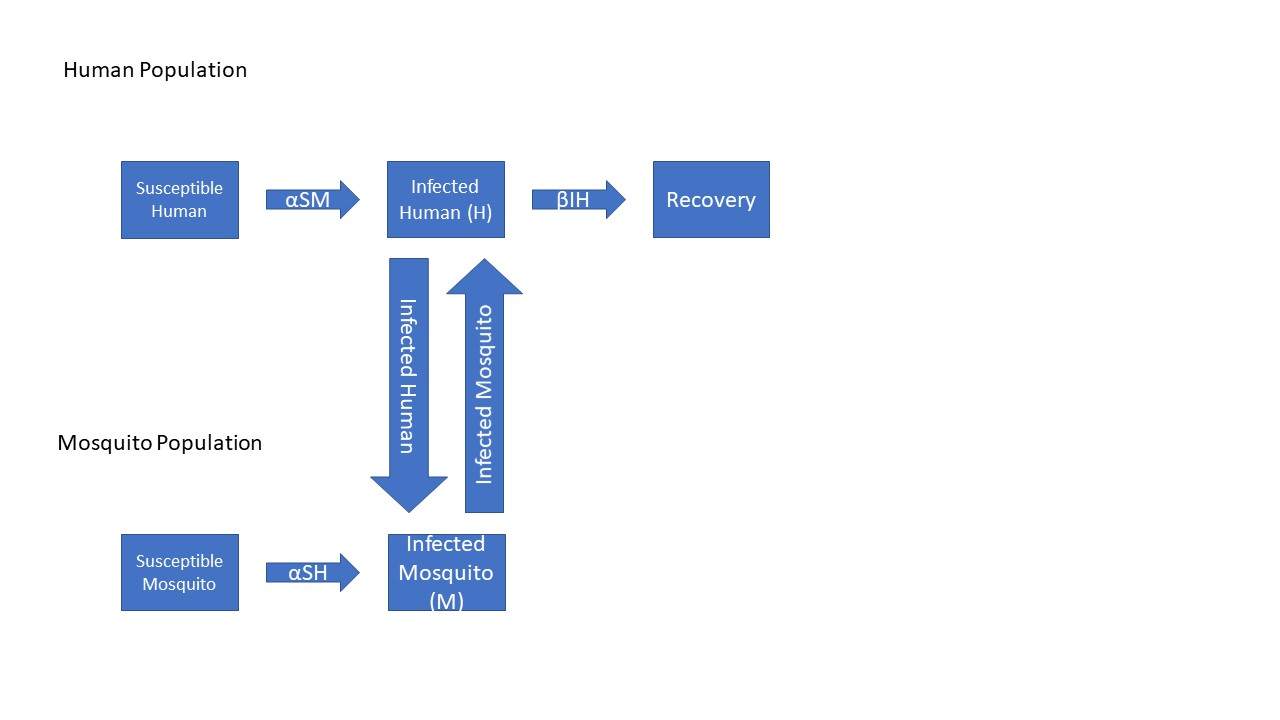

Susceptible humans are infected by infected mosquitos. Susceptible mosquitos are infected by infected humans. The relationship between susceptible and infected humans depeneds on the number of infected mosquitos. The relationship between susceptible and infected mosquitos depeneds on the number of infected humans. Humans cannot infect other humans and other mosquitos cannot infect other mosquitos.

# Step 3

Susceptible Humans (SH) = 12,200,000 
Infected Humans (IH) = .01
Recovered (R) = 0
Died (D)

Susceptible Mosquitos (SM) = 100
Infected Mosquitos (IM) = 1

num_contacts = 1
prob_trans = 301/1000
duration = 10

beta(Infection rate for people) = num_contacts * prob_trans
 - Infection rate depends on num mosquitos in an area and probability of contact with susceptible mosquito
 
alpha(Infection rate for mosquito) = 
 - Infection rate depends on prob to bite infected human
gamma(Recovery rate) = 1/duration

sim_length = 60

In [2]:
def rk4(func, initial, deltas):
    ys = [initial]
    for i in range(1, len(xs)):
        old = np.array(ys[-1][:])
        dt = xs[i] - xs[i - 1]
        d1 = np.array(func(old, xs[i])) * dt
        d2 = np.array(func(old + 0.5 * d1, xs[i] + 0.5 * dt)) * dt
        d3 = np.array(func(old + 0.5 * d2, xs[i] + 0.5 * dt)) * dt
        d4 = np.array(func(old + d3, xs[i] + dt)) * dt
        better = old + ((d1 + 2 * d2 + 2 * d3 + d4) / 6.0)
        ys.append(better)
    return np.array(ys)

In [3]:
POP = 12200000
IH = POP/20
SH = POP-IH
R = 0
D = 0

IM = 1
SM= POP - IM
DM = 0

duration = 14
mosquito_lifespan = 14

num_contacts = 1
prob_trans = .32

beta = num_contacts * prob_trans/POP
betam = num_contacts/POP
gamma = 1/duration
delta = .00177
theta = .01

sim_length = 60

Probability of infection from mosquito bite found [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5230737/).

Death rate calculated from [this](https://www.who.int/news-room/fact-sheets/detail/malaria) website (data is from 2018, so it may be slightly outdated).

In [4]:
def SIR(u, t):
    SH, IH, D, R, SM, IM, DM = u
    dSH = -beta * IM * SH
    dIH = beta * IM * SH - gamma * IH - delta *IH
    dD = delta * IH
    dR = gamma * IH
    dSM = - betam * IH * SM
    dIM = betam * IH * SM - theta * IM
    dDM = theta * IM
    return np.array([dSH, dIH, dD, dR, dSM, dIM, dDM])

In [5]:
xs = np.linspace(0, sim_length, sim_length * 30)
ys = rk4(SIR, [SH, IH, D, R, SM, IM, DM], xs)

In [6]:
df = pd.DataFrame(ys, columns=["Susceptible Human", "Infected Human", "Human Deaths","Recovered", "Susceptible Mosquito", "Infected Mosquito","Mosquito Deaths"])
df["Time"] = xs

In [7]:
dfmelt=pd.melt(df, id_vars=['Time'], 
               value_vars=["Susceptible Human", "Infected Human", "Human Deaths", "Recovered", "Susceptible Mosquito", "Infected Mosquito", "Mosquito Deaths"], 
               var_name='Categories', value_name='Population')
dfmelt

,Time,Categories,Population
0,0.000000,Susceptible Human,1.159000e+07
1,0.033352,Susceptible Human,1.158990e+07
2,0.066704,Susceptible Human,1.158959e+07
3,0.100056,Susceptible Human,1.158908e+07
4,0.133407,Susceptible Human,1.158836e+07
...,...,...,...
12595,59.866593,Mosquito Deaths,5.095763e+06
12596,59.899944,Mosquito Deaths,5.098132e+06
12597,59.933296,Mosquito Deaths,5.100500e+06
12598,59.966648,Mosquito Deaths,5.102867e+06


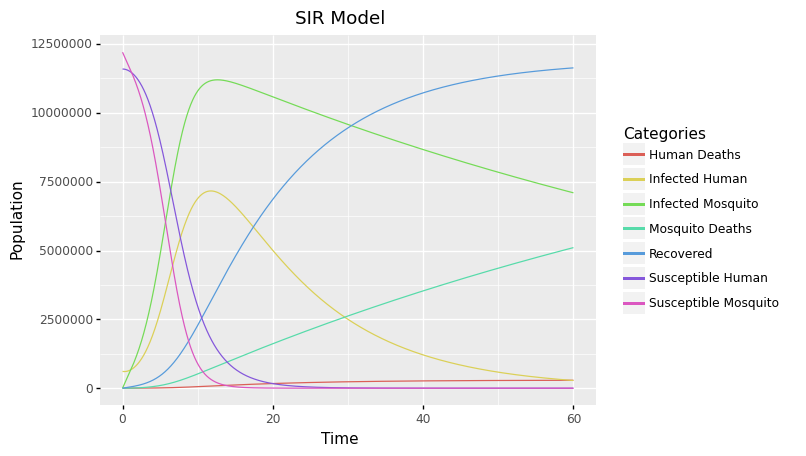

<ggplot: (-9223371857754958468)>

In [8]:
ggplot(dfmelt, aes(x="Time", y="Population", color="Categories")) \
+ geom_line() \
+ labs(title="SIR Model")

From our first graph we can see that there is a large population of susceptible mosquitoes and susceptible humans. There are currently no recovered humans at time 0. We also do not have a recovered mosquito category because mosquitoes tend to have a short life span and coupled with an infection usually leads to death, so no recovered mosquitoes. We see that over time, as infected mosquitoes and humans are introduced into the population, the number of infected human and recovered start to increase. The once susceptible has now become infected. Slowly, the number of infected humans begin to decrease as the number of recovered start to increase as well. Infected mosquitoes eventually become deceased mosquitoes.

This chart is not an accurate model of what actaully happens. It can be greatly improved by adding in factors such as recovered humans becoming susceptible again, natural mosquito birth, and seasonal changes. 

We are now going to implement seasonal peaks into the equations. 

We will also tweak our chart a bit. There does not seem to be any immunity period with malaria, so any human who is no longer infected will now go back into susceptible. We will also add in a natural birth for the mosquitos.

In [9]:
import math
def bt(t):
    return beta * (1 - math.cos(25 * math.radians(t)))
def btm(t):
    return beta * (1 - math.cos(25 * math.radians(t)))

In [10]:
alpha = .001 * (SM + IM)

In [11]:
rain_months = [1,2,6,7]
def rainy(t):
    return t%12 in rain_months
def SIR(u, t):
    SH, IH, D, SM, IM, DM = u
    dSH = -bt(t) * IM * SH + gamma * IH
    dIH = bt(t) * IM * SH - gamma * IH - delta * IH
    dD = delta * IH
    if rainy:
        dSM = -btm(t) * IH * SM + alpha * 20
    else:
        dSM = -btm(t) * IH * SM + alpha
    dIM = btm(t) * IH * SM - theta * IM
    dDM = theta * IM
    return np.array([dSH, dIH, dD, dSM, dIM, dDM])

In [12]:
xs = np.linspace(0, sim_length, sim_length * 30)
ys = rk4(SIR, [SH, IH, D, SM, IM, DM], xs)

In [13]:
df = pd.DataFrame(ys, columns=["Susceptible Human", "Infected Human","Human Deaths","Susceptible Mosquito", "Infected Mosquito", "Mosquito Deaths"])
df["Time"] = xs

In [14]:
dfmelt=pd.melt(df, id_vars=['Time'], 
               value_vars=["Susceptible Human", "Infected Human","Human Deaths","Susceptible Mosquito", "Infected Mosquito", "Mosquito Deaths"], 
               var_name='Categories', value_name='Population')
dfmelt

,Time,Categories,Population
0,0.000000,Susceptible Human,1.159000e+07
1,0.033352,Susceptible Human,1.159145e+07
2,0.066704,Susceptible Human,1.159290e+07
3,0.100056,Susceptible Human,1.159434e+07
4,0.133407,Susceptible Human,1.159578e+07
...,...,...,...
10795,59.866593,Mosquito Deaths,7.641974e+06
10796,59.899944,Mosquito Deaths,7.647803e+06
10797,59.933296,Mosquito Deaths,7.653632e+06
10798,59.966648,Mosquito Deaths,7.659461e+06


Based off of the climate data found at [this](https://www.expertafrica.com/rwanda/weather-and-climate) site March, April, October, and November all have rain fall of over 100mm, so any time it is one of those months the mosquitoes will reproduce much more quickly. 

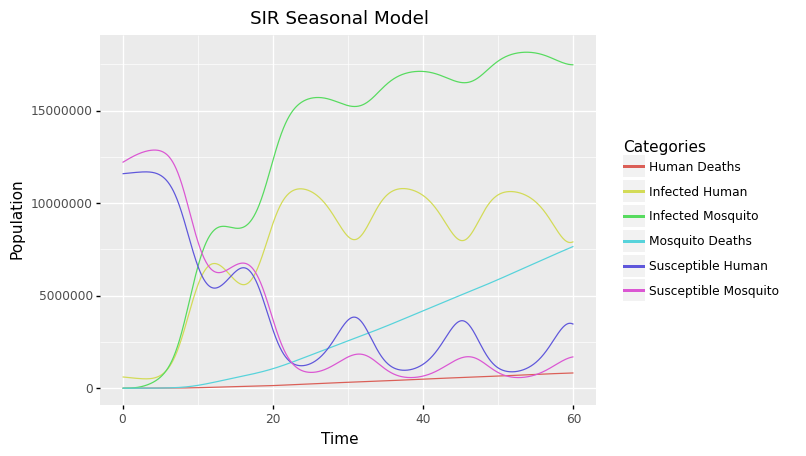

<ggplot: (-9223371857746412568)>

In [15]:
ggplot(dfmelt, aes(x="Time", y="Population", color="Categories")) \
+ geom_line() \
+ labs(title="SIR Seasonal Model")

This graph is an improvement on the last one, now that humans are no longer static after a certain amount of time. However now that we have mosquitoes having natural deaths and births, the total number of mosquitoes increase infinitley. It is still making a lot of assumptions, such as rates of death and birth, along with no maturing time period for newly born mosquitoes. 

In [this](https://www.who.int/docs/default-source/documents/publications/gmp/who-cds-gmp-2019-17-eng.pdf?ua=1) publication by WHO, there is a lot of data on the efficiacy of malaria resistant drugs. At the top of the second page, it lists three drugs and their efficiacy, with an average success rate of 98.6%. In the beginning of the article, it also states that roughyl 5% of mosquitoes in Rwanda, along with other regions, have genomes that make them at least partially resistant to these drugs.

In [16]:
no_drugs = SH*.25
drugs_dont_work = SH * .75 * .014
resistant_mosquitoes = SH * .75 * .05
SH = no_drugs + drugs_dont_work + resistant_mosquitoes

In [17]:
rain_months = [1,2,6,7]
def rainy(t):
    return t%12 in rain_months
sim_length = 60
def SIR(u, t):
    SH, IH, D, SM, IM, DM = u
    dSH = -bt(t) * IM * SH + gamma * IH
    dIH = bt(t) * IM * SH - gamma * IH - delta * IH
    dD = delta * IH
    if rainy:
        dSM = -btm(t) * IH * SM + alpha * 20
    else:
        dSM = -btm(t) * IH * SM + alpha
    dIM = btm(t) * IH * SM - theta * IM
    dDM = theta * IM
    return np.array([dSH, dIH, dD, dSM, dIM, dDM])

In [18]:
xs = np.linspace(0, sim_length, sim_length * 30)
ys = rk4(SIR, [SH, IH, D, SM, IM, DM], xs)

In [19]:
df = pd.DataFrame(ys, columns=["Susceptible Human", "Infected Human","Human Deaths","Susceptible Mosquito", "Infected Mosquito", "Mosquito Deaths"])
df["Time"] = xs

In [20]:
dfmelt=pd.melt(df, id_vars=['Time'], 
               value_vars=["Susceptible Human", "Infected Human","Human Deaths","Susceptible Mosquito", "Infected Mosquito", "Mosquito Deaths"], 
               var_name='Categories', value_name='Population')
dfmelt

,Time,Categories,Population
0,0.000000,Susceptible Human,3.453820e+06
1,0.033352,Susceptible Human,3.455271e+06
2,0.066704,Susceptible Human,3.456719e+06
3,0.100056,Susceptible Human,3.458164e+06
4,0.133407,Susceptible Human,3.459604e+06
...,...,...,...
10795,59.866593,Mosquito Deaths,5.982390e+06
10796,59.899944,Mosquito Deaths,5.988091e+06
10797,59.933296,Mosquito Deaths,5.993791e+06
10798,59.966648,Mosquito Deaths,5.999491e+06


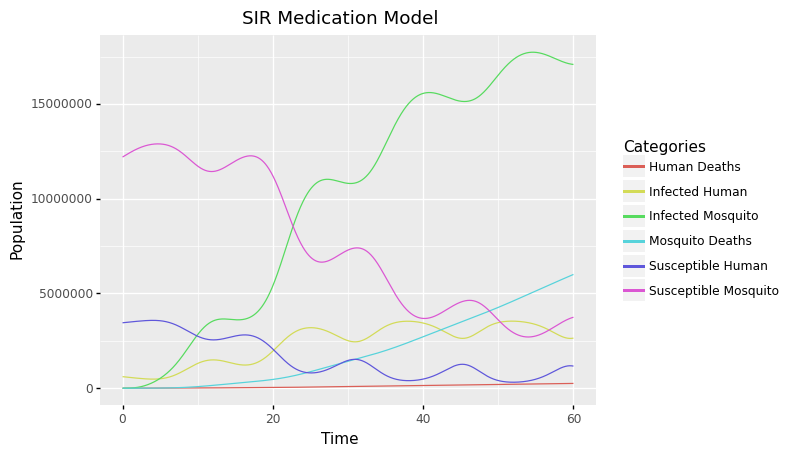

<ggplot: (-9223371857747974108)>

In [21]:
ggplot(dfmelt, aes(x="Time", y="Population", color="Categories")) \
+ geom_line() \
+ labs(title="SIR Medication Model")

Due to there being a much smaller amount of people who are susceptible, the number of infected humans does not get as high as last time. Because of this the number of susceptible mosquitoes do not deteriorate as quickly. 

In [22]:
rain_months = [1,2,6,7]
def rainy(t):
    return t%12 in rain_months
sim_length = 60
def SIR(u, t):
    past_april = 1
    if t > 18:
        past_april = .1
    SH, IH, D, SM, IM, DM = u
    dSH = -bt(t) * IM * SH + gamma * IH
    dIH = bt(t) * IM * SH - gamma * IH - delta * IH
    dD = delta * IH
    if rainy:
        dSM = -btm(t) * IH * SM + alpha * 20 * past_april
    else:
        dSM = -btm(t) * IH * SM + alpha * past_april
    dIM = btm(t) * IH * SM - theta * IM
    dDM = theta * IM
    return np.array([dSH, dIH, dD, dSM, dIM,dDM])

In [23]:
xs = np.linspace(0, sim_length, sim_length * 30)
ys = rk4(SIR, [SH, IH, D, SM, IM, DM], xs)

In [24]:
df = pd.DataFrame(ys, columns=["Susceptible Human", "Infected Human","Human Deaths","Susceptible Mosquito", "Infected Mosquito", "Mosquito Deaths"])
df["Time"] = xs

In [25]:
dfmelt=pd.melt(df, id_vars=['Time'], 
               value_vars=["Susceptible Human", "Infected Human","Human Deaths","Susceptible Mosquito", "Infected Mosquito", "Mosquito Deaths"], 
               var_name='Categories', value_name='Population')
dfmelt

,Time,Categories,Population
0,0.000000,Susceptible Human,3.453820e+06
1,0.033352,Susceptible Human,3.455271e+06
2,0.066704,Susceptible Human,3.456719e+06
3,0.100056,Susceptible Human,3.458164e+06
4,0.133407,Susceptible Human,3.459604e+06
...,...,...,...
10795,59.866593,Mosquito Deaths,4.966453e+06
10796,59.899944,Mosquito Deaths,4.970404e+06
10797,59.933296,Mosquito Deaths,4.974354e+06
10798,59.966648,Mosquito Deaths,4.978303e+06


According to the data found in the NIH's article regarding a genetically modified mosquito who have boosted immune activity in their guts so that the parasite that causes malaria cannot reproduce, the children between these modified mosquitoes and regular mosquitoes will be immune to the parasite 90% of the time. With this, we can model what it will look like if they were to be released about a quarter through our simulation. 

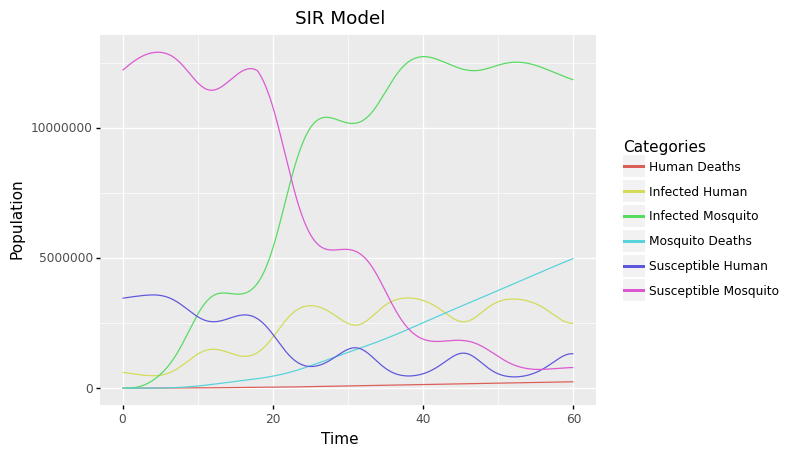

<ggplot: (-9223371857746193684)>

In [26]:
ggplot(dfmelt, aes(x="Time", y="Population", color="Categories")) \
+ geom_line() \
+ labs(title="SIR Model")

Once the model hits April of 2022 (19 on Time) the birth rate is reduced to a tenth since 90% of the offspring will be immune. As can bee seen from the graph, by the end of the 60 months, the number of infected mosquitos is right underneath 12.5 million, as compared to almost 20 million in the last graph. To better demonstrate the effectivness of these genetically modified mosquitoes, the graph below shows if these were released in October of 2020, of which they do not even reach 10 million in population.

In [27]:
rain_months = [1,2,6,7]
def rainy(t):
    return t%12 in rain_months
sim_length = 60
def SIR(u, t):
    SH, IH, D, SM, IM, DM = u
    dSH = -bt(t) * IM * SH + gamma * IH
    dIH = bt(t) * IM * SH - gamma * IH - delta * IH
    dD = delta * IH
    if rainy:
        dSM = -btm(t) * IH * SM + alpha * 20 *.1
    else:
        dSM = -btm(t) * IH * SM + alpha * .1
    dIM = btm(t) * IH * SM - theta * IM
    dDM = theta * IM
    return np.array([dSH, dIH, dD, dSM, dIM,dDM])

In [28]:
xs = np.linspace(0, sim_length, sim_length * 30)
ys = rk4(SIR, [SH, IH, D, SM, IM, DM], xs)

In [29]:
df = pd.DataFrame(ys, columns=["Susceptible Human", "Infected Human","Human Deaths","Susceptible Mosquito", "Infected Mosquito", "Mosquito Deaths"])
df["Time"] = xs

In [30]:
dfmelt=pd.melt(df, id_vars=['Time'], 
               value_vars=["Susceptible Human", "Infected Human","Human Deaths","Susceptible Mosquito", "Infected Mosquito", "Mosquito Deaths"], 
               var_name='Categories', value_name='Population')
dfmelt

,Time,Categories,Population
0,0.000000,Susceptible Human,3.453820e+06
1,0.033352,Susceptible Human,3.455271e+06
2,0.066704,Susceptible Human,3.456719e+06
3,0.100056,Susceptible Human,3.458164e+06
4,0.133407,Susceptible Human,3.459604e+06
...,...,...,...
10795,59.866593,Mosquito Deaths,3.770453e+06
10796,59.899944,Mosquito Deaths,3.773491e+06
10797,59.933296,Mosquito Deaths,3.776528e+06
10798,59.966648,Mosquito Deaths,3.779565e+06


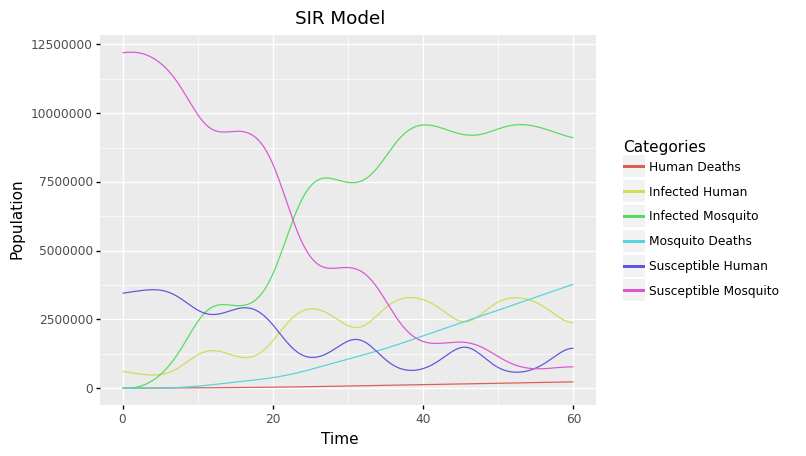

<ggplot: (-9223371857746190304)>

In [31]:
ggplot(dfmelt, aes(x="Time", y="Population", color="Categories")) \
+ geom_line() \
+ labs(title="SIR Model")

# Evaluation

Write a summary of your modeling results and the process your team used to create your simulations. How sensitive is your model to the assumptions you made in finding population numbers and rates of change? What do you think is the largest problem with your model? How else would you augment the model going forward?

From our modeling results we can see that there are multiple factors that can affect the cycle of malaria. From our first graph, we have a cut and dry model that shows the relationship between Malaria transmition in humans and mosquitoes. We start to introduce other factors such as climate change, antimalarial drugs, and genetically engineered mosquitoes which cause our graphs to fluctuate. For climate change we modeled if off of Dr. Goadrich's usage of cosine in his Epidemiology revisited notebook. We used cosine to map mosquito reproduction, assuming that the peaks in the graphs are due to wetter seasons and the dips are due to dryer climates. We also assume that when infected mosquitoes peak, so do infected humans, which then the susceptible human and mosquito dip to offset the change from susceptible to infected. We see that the rainy season have no affect in mosquito and human death assuming that death is constant and should not fluctuate depending on climate change. We continue to use cosine when antimalarial drugs are introduced. We changed the number of susceptible humans dependent to the efficacy of the antimalarial drugs. Those still susceptible means that the drug did not protect them from contacting malaria. We also accounted for mosquitoes who were resistant to the antimalarial drug. This information was pulled off of the WHO website. In the medication graph, the antimalarial drugs help people and mosquitoes from getting infected so the growth of infected humans and moquitoes grow slower. The rate at which humans are infected grow much slower than the previous graph but rate of growth for infected mosquitoes are still high. In the genetically engineered mosquito model, this graph looks a bit like the previous graphs but after April 2022, or 19 on the graph, 90% of mosquitoes should now be immune so only 10% are susceptible to contacting malaria. Our model is only based on an average of what is found in the articles we read. So in a perfect world where there is consistent climate change and mosquitoes do not build tolerance to antimalarial drugs or genetically engineered mosquitoes do not disrupt the natural order, these models would be very accurate. The largest problem in our graphs besides inevitable limitations is our assumptions themselves, more specifically the rate of transmission. We had to just pick a reasonable number based off of our research. For our next steps, we could gather more information about rate of transmission and take an average of those findings.